# PROJECT-3. Анализ воронки
### Пархоменко Евгения Александровна
#### DARP 1014

### ОПИСАНТЕ ГИПОТЕЗЫ
Проверим три предположения:
- Должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?
- Верно ли, что повторное прохождение обучения положительно влияет на оплату?
- Если пользователь сначала выбирает уровень сложности, будет ли он потом проходить обучение?

Проверку будем производить на основе данных пользователей, которые зарегистрировались в 2018 году.

### ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

### ЗАДАЧИ
В рамках проверки гипотез вам необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

### Ход проверки

Импортируем нужные библиотеки

In [282]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Получаем данные

In [283]:
event = pd.read_csv("C:/IDE/Dataset/7_4_Events.csv")
events_df = event.copy()
# переименум колонку  id  в  event_id
events_df = events_df.rename(columns={'id':'event_id'})

In [284]:
purchase  = pd.read_csv("C:/IDE/Dataset/purchase.csv")
purchase_df = purchase.copy()
# переименум колонку  id  в  purchase_id и event_datetime в start_time
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

По условию, все задания необходимо выполнять с использованием данных пользователей, зарегистрировавшихся в 2018 году.

In [285]:
# Определяем дату начала и конца нашей выборки (2018)
mask_even_1 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01')

# Выбираем только зарегестрированых пользователей
mask_even_2 = events_df['event_type'] == 'registration'

# Cоздаем список пользователей зарегистировавшихся в 2018 году
users_even_2018 = events_df[mask_even_1 & mask_even_2]['user_id'].to_list()

# Применяем наш список зарегистрировавшихся в 2018 году пользователей к таблице,
# тем самым убирая из нее пользователей, которые не попали в этот список
events_df = events_df[events_df['user_id'].isin(users_even_2018)]

# Смотрим результат (из 252334 пользователей осталось 66959)
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_id        66959 non-null  int64  
 1   event_type      66959 non-null  object 
 2   selected_level  8342 non-null   object 
 3   start_time      66959 non-null  object 
 4   tutorial_id     32954 non-null  float64
 5   user_id         66959 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.6+ MB


Применяем наш список зарегистрировавшихся в 2018 году пользователей к таблице,тем самым убирая из нее пользователей, которые не попали в этот список

In [286]:
purchase_df = purchase_df[purchase_df['user_id'].isin(users_even_2018)]
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   purchase_id  1600 non-null   int64 
 1   user_id      1600 non-null   int64 
 2   start_time   1600 non-null   object
 3   amount       1600 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


Произведем преобразование типов

In [287]:
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
purchase_df['start_time'] = pd.to_datetime(purchase_df['start_time'])

Добавим в датафрейм purchase_df столбец event_type, который будет содержать одно значение purchase. Это нужно, чтобы в объединённом датафрейме однозначно выделить события оплаты.

In [288]:
purchase_df['event_type'] = 'purchase'

Сделаем объединенный датафрейм из событий и оплат

In [289]:
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df.head(3)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN


In [290]:
total_events_df['event_type'].unique() # убрать

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

In [291]:
total_events_df.groupby(['event_type'])['user_id'].count() # Убрать

event_type
level_choice        8342
pack_choice         5737
purchase            1600
registration       19926
tutorial_finish    14904
tutorial_start     18050
Name: user_id, dtype: int64

### Проверяем гипотезу № 1
- Должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Создадим сводную таблицу по минимальному времени начала этапа для подсчета дальнейше разницы

In [292]:
pivot_df = total_events_df.pivot_table(values='start_time', index='user_id', columns='event_type', aggfunc='min') 

Посчитаем время между этапами.
Послеловательность: 
- Регистрация 
- Старт обучения 
- Завершение обучения 
- Выбор уровня сложности вопросов 
- Выбор пакетов вопросов 
- Покупка платных пакетов вопросов

In [293]:
# время от регистрации до начала обучения
pivot_df['delta_tutorial_start'] = (pivot_df['tutorial_start'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от регистрации до конца обучения
pivot_df['delta_tutorial_finish'] = (pivot_df['tutorial_finish'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время на всю последовательность
pivot_df['delta_all_time'] = (pivot_df['purchase'] - pivot_df['registration'])/ pd.Timedelta('1 hour') 
# время от выбоара сложности до окончания обучения
pivot_df['delta_level_choice'] = (pivot_df['level_choice'] - pivot_df['tutorial_finish'])/ pd.Timedelta('1 hour') 
# время от выбора сложности до покупки
pivot_df['delta_pack_choice'] = (pivot_df['pack_choice'] - pivot_df['level_choice'])/ pd.Timedelta('1 hour') 
# время на оплату
pivot_df['delta_purchase'] = (pivot_df['purchase'] - pivot_df['pack_choice'])/ pd.Timedelta('1 hour') 
pivot_df = pivot_df.reset_index()

Посчитаем среднее время по столбцам

Создадим списки пользователей:
- список всех пользователей (all_users);
- пользователи, которые начинали обчение (users_with_started_tutorial);
- пользовватели, которые не начинали обучение (not_start_tutorial);
- пользователи, которые завершили обучение (tutorial_finished_users).

In [294]:
all_users = set(total_events_df['user_id'].unique())
users_with_started_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'])
not_start_tutorial = set(all_users.difference(users_with_started_tutorial))
tutorial_finished_users = set(total_events_df[total_events_df["event_type"] == "tutorial_finish"]['user_id'])
users_not_finished_tutorial = set(users_with_started_tutorial.difference(tutorial_finished_users))

Создадим новый признак 'group', где разделим  всех пользователей на группы

In [295]:
def get_tutorial_status (user_id):
    if user_id in not_start_tutorial:
        return 'not_started'
    elif user_id in tutorial_finished_users:
        return 'finished'
    elif user_id in users_not_finished_tutorial:
        return 'not_finished' 
    
pivot_df['group'] = pivot_df['user_id'].apply(get_tutorial_status)

Расчитаем среднее время, затраченное различными группами пользователей, на прохождение игры (от этапа регистрации, до совершения покупки)

In [296]:
user_group = pivot_df.groupby(['group'], as_index=False)['delta_all_time'].mean().round(2)

Строим график

In [297]:
fig = px.bar(
    data_frame=user_group,
    x="group",
    y="delta_all_time",
    text = 'delta_all_time',
    orientation='v',
    height=500,
    width=1000,
    title='Влияние прохождения этапа обучения на скорость прохождения игры'
)
fig.show()

### ВЫВОД: 
#### успешное обучение приближает пользователя к покупке.
- быстрее всего покупку совершают пользователи, которые успешно завершили обучение;
- у пользователей, которые начали обучение, но не завершили его, тратят больше времени до совершения покупки. Но все же они совешают покупку быстрее, чем пользователи, которые не начинали обучение;
- дольше всего к этапу покупки подходят пользователи, кторые не начинали обучение.


### Проверяем гипотезу № 2
- Верно ли, что повторное прохождение обучения положительно влияет на оплату (существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.)?



Формируем DataFrame по количеству начинаний обучений 

In [298]:
count_start = total_events_df[total_events_df['event_type'] == 'tutorial_start'].groupby(by='user_id', as_index = False)['event_type'].count()
count_start = count_start.rename(columns={'event_type':'count_start'})
count_start

,user_id,count_start
0,27833,1
1,27834,1
2,27835,1
3,27836,2
4,27839,1
...,...,...
11853,47748,1
11854,47751,1
11855,47753,1
11856,47755,1


Формируем DataFrame по количеству завершений обучений 

In [299]:
count_finish = total_events_df[total_events_df['event_type'] == 'tutorial_finish'].groupby(by='user_id', as_index = False)['event_type'].count()
count_finish = count_finish.rename(columns={'event_type':'count_finish'})
count_finish

,user_id,count_finish
0,27833,1
1,27834,1
2,27835,1
3,27836,1
4,27839,1
...,...,...
10245,47748,1
10246,47751,1
10247,47753,1
10248,47755,1


Формируем DataFrame по количеству оплат

In [300]:
clients_df = total_events_df[total_events_df['event_type'] == 'purchase'].groupby(by='user_id', as_index = False)['amount'].count()
clients_df

,user_id,amount
0,27845,1
1,27865,1
2,27884,1
3,27910,1
4,27911,1
...,...,...
1595,47671,1
1596,47687,1
1597,47712,1
1598,47732,1


Объеденяем DataFrame count_start и count_finish в промежуточный DataFrame merged_1

In [301]:
merged_1 = count_start.merge(
    count_finish, 
    on='user_id',
    how='left'
)
merged_1

,user_id,count_start,count_finish
0,27833,1,1.0
1,27834,1,1.0
2,27835,1,1.0
3,27836,2,1.0
4,27839,1,1.0
...,...,...,...
11853,47748,1,1.0
11854,47751,1,1.0
11855,47753,1,1.0
11856,47755,1,1.0


Объеденяем DataFrame merged_1 и clients_df в итоговый DataFrame conversion_df


In [302]:
conversion_df = merged_1.merge(
    clients_df, 
    on='user_id',
    how='left'
)
conversion_df['count_finish'] = pd.to_numeric(conversion_df['count_finish'], errors='coerce').fillna(0).astype('int64')
conversion_df

,user_id,count_start,count_finish,amount
0,27833,1,1,NaN
1,27834,1,1,NaN
2,27835,1,1,NaN
3,27836,2,1,NaN
4,27839,1,1,NaN
...,...,...,...,...
11853,47748,1,1,NaN
11854,47751,1,1,NaN
11855,47753,1,1,NaN
11856,47755,1,1,NaN


C:\Users\Евгения\AppData\Local\Temp\ipykernel_16724\1082318394.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



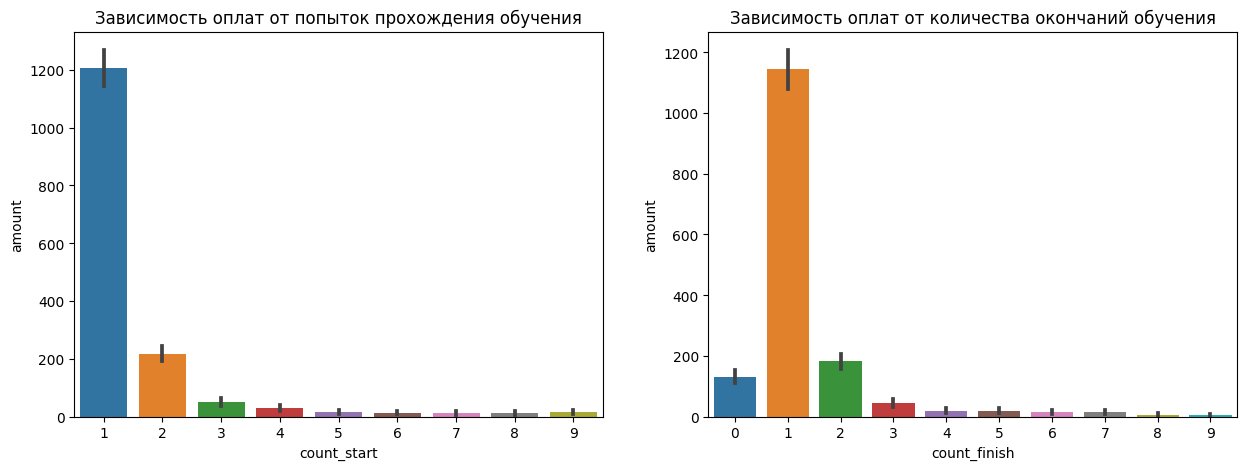

In [303]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# gthdsq uhfabr
barplot1 = sns.barplot(
    data = conversion_df,
    x = 'count_start',
    y = 'amount',
    estimator = 'sum',
    ax = axes[0]
)
axes[0].set_title('Зависимость оплат от попыток прохождения обучения')

barplot2 = sns.barplot(
    data = conversion_df,
    x = 'count_finish',
    y = 'amount',
    estimator = 'sum',
    ax = axes[1]
)
axes[1].set_title('Зависимость оплат от количества окончаний обучения')


fig.show()

In [ ]:
count_start_1 = conversion_df['count_start'].groupby(by='count_start', as_index = False)['amount'].count()
count_start_1

In [306]:
count_start_1 = conversion_df.groupby('count_start', as_index = False)['amount'].count()
count_start_1

,count_start,amount
0,1,1207
1,2,218
2,3,51
3,4,30
4,5,16
5,6,14
6,7,12
7,8,13
8,9,17


In [307]:
count_start_2 = conversion_df.groupby('count_finish', as_index = False)['amount'].count()
count_start_2

,count_finish,amount
0,0,131
1,1,1143
2,2,182
3,3,44
4,4,19
5,5,19
6,6,15
7,7,15
8,8,6
9,9,4


# ЧЕРНОВИКИ

In [ ]:
pivot_df = pivot_df.reset_index(drop=True).transpose()
pivot_df.columns = pivot_df.iloc[0]
pivot_df = pivot_df.iloc[1:]
pivot_df.index.rename('group', inplace=True)
pivot_df = pivot_df.reset_index()